# Model Comparison & Rolling Window Backtesting
## Compare baseline vs enhanced model + seasonal validation

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("=" * 100)
print("MODEL COMPARISON & ROLLING WINDOW BACKTESTING")
print("=" * 100)

MODEL COMPARISON & ROLLING WINDOW BACKTESTING


## Part 1: Compare Baseline vs Enhanced Model

In [2]:
# Load both model results
model_files = sorted(Path('../models').glob('lgbm_results_*.json'))

if len(model_files) < 2:
    print(f"⚠️ Only {len(model_files)} model(s) found. Need at least 2 for comparison.")
    print("Available models:")
    for f in model_files:
        print(f"  - {f.name}")
else:
    # Get the two most recent models
    model1_path = model_files[-2]  # Baseline (older)
    model2_path = model_files[-1]  # Enhanced (newer)
    
    print(f"\nComparing:")
    print(f"  Baseline:  {model1_path.name}")
    print(f"  Enhanced:  {model2_path.name}")
    
    with open(model1_path, 'r') as f:
        model1 = json.load(f)
    
    with open(model2_path, 'r') as f:
        model2 = json.load(f)
    
    # Create comparison dataframe
    comparison_data = {
        'Metric': [
            'Dataset Size', 'Num Features', 'Num Buildings',
            'Train Size', 'Test Size',
            'RMSE (Train)', 'RMSE (Test)', 
            'MAE (Train)', 'MAE (Test)',
            'R² (Train)', 'R² (Test)',
            'WAPE (Test)', 'sMAPE (Test)',
            'vs 1h Baseline (%)', 'vs 24h Baseline (%)',
            'Best Iteration'
        ],
        'Baseline Model': [
            model1['dataset_size'], model1['num_features'], model1['num_buildings'],
            model1['train_size'], model1['test_size'],
            model1['train_rmse'], model1['test_rmse'],
            model1['train_mae'], model1['test_mae'],
            model1['train_r2'], model1['test_r2'],
            model1['test_wape'], model1['test_smape'],
            model1['improvement_vs_1h'], model1['improvement_vs_24h'],
            model1['best_iteration']
        ],
        'Enhanced Model': [
            model2['dataset_size'], model2['num_features'], model2['num_buildings'],
            model2['train_size'], model2['test_size'],
            model2['train_rmse'], model2['test_rmse'],
            model2['train_mae'], model2['test_mae'],
            model2['train_r2'], model2['test_r2'],
            model2['test_wape'], model2['test_smape'],
            model2['improvement_vs_1h'], model2['improvement_vs_24h'],
            model2['best_iteration']
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Calculate differences (skip non-numeric first 5 rows)
    comparison_df['Difference'] = comparison_df['Enhanced Model'] - comparison_df['Baseline Model']
    comparison_df['% Change'] = np.where(
        comparison_df['Baseline Model'] != 0,
        (comparison_df['Difference'] / comparison_df['Baseline Model'].abs()) * 100,
        0
    )
    
    print("\n" + "="*100)
    print("MODEL COMPARISON TABLE")
    print("="*100)
    print(comparison_df.to_string(index=False))


Comparing:
  Baseline:  lgbm_results_20251109_180339.json
  Enhanced:  lgbm_results_20251109_191953.json

MODEL COMPARISON TABLE
             Metric  Baseline Model  Enhanced Model  Difference  % Change
       Dataset Size    1.229140e+07    1.229140e+07    0.000000  0.000000
       Num Features    2.000000e+01    2.000000e+01    0.000000  0.000000
      Num Buildings    1.449000e+03    1.449000e+03    0.000000  0.000000
         Train Size    8.513207e+06    8.513207e+06    0.000000  0.000000
          Test Size    3.778192e+06    3.778192e+06    0.000000  0.000000
       RMSE (Train)    1.646012e+02    1.677280e+02    3.126717  1.899571
        RMSE (Test)    1.816253e+02    1.822918e+02    0.666504  0.366967
        MAE (Train)    4.223041e+01    4.277849e+01    0.548079  1.297830
         MAE (Test)    4.701747e+01    4.742304e+01    0.405572  0.862598
         R² (Train)    9.860088e-01    9.854722e-01   -0.000537 -0.054421
          R² (Test)    9.826326e-01    9.825049e-01   -0

In [3]:
# Performance Summary
print("\n" + "="*100)
print("PERFORMANCE SUMMARY")
print("="*100)

# RMSE Analysis
test_rmse_diff = model2['test_rmse'] - model1['test_rmse']
test_rmse_pct = (test_rmse_diff / model1['test_rmse']) * 100

print(f"\n📊 TEST RMSE:")
print(f"   Baseline:  {model1['test_rmse']:.4f} kWh")
print(f"   Enhanced:  {model2['test_rmse']:.4f} kWh")
if test_rmse_diff < 0:
    print(f"   ✅ IMPROVEMENT: {abs(test_rmse_diff):.4f} kWh ({abs(test_rmse_pct):.2f}% better)")
else:
    print(f"   ❌ DEGRADATION: {test_rmse_diff:.4f} kWh ({test_rmse_pct:.2f}% worse)")

# MAE Analysis
test_mae_diff = model2['test_mae'] - model1['test_mae']
test_mae_pct = (test_mae_diff / model1['test_mae']) * 100

print(f"\n📊 TEST MAE:")
print(f"   Baseline:  {model1['test_mae']:.4f} kWh")
print(f"   Enhanced:  {model2['test_mae']:.4f} kWh")
if test_mae_diff < 0:
    print(f"   ✅ IMPROVEMENT: {abs(test_mae_diff):.4f} kWh ({abs(test_mae_pct):.2f}% better)")
else:
    print(f"   ❌ DEGRADATION: {test_mae_diff:.4f} kWh ({test_mae_pct:.2f}% worse)")

# R² Analysis
test_r2_diff = model2['test_r2'] - model1['test_r2']
test_r2_pct = (test_r2_diff / model1['test_r2']) * 100

print(f"\n📊 TEST R²:")
print(f"   Baseline:  {model1['test_r2']:.6f}")
print(f"   Enhanced:  {model2['test_r2']:.6f}")
if test_r2_diff > 0:
    print(f"   ✅ IMPROVEMENT: +{test_r2_diff:.6f} ({test_r2_pct:.4f}% better)")
else:
    print(f"   ❌ DEGRADATION: {test_r2_diff:.6f} ({test_r2_pct:.4f}% worse)")

# Overfitting Analysis
print(f"\n📊 OVERFITTING ANALYSIS (Test/Train RMSE Ratio):")
model1_overfit = model1['test_rmse'] / model1['train_rmse']
model2_overfit = model2['test_rmse'] / model2['train_rmse']

print(f"   Baseline:  {model1_overfit:.4f}")
print(f"   Enhanced:  {model2_overfit:.4f}")

if model2_overfit < model1_overfit:
    print(f"   ✅ Enhanced model shows BETTER generalization (closer to 1.0)")
else:
    print(f"   ⚠️ Baseline model shows better generalization")

if model2_overfit > 1.15:
    print(f"   ⚠️ WARNING: Enhanced model may be overfitting (ratio > 1.15)")
elif model2_overfit > 1.10:
    print(f"   ⚠️ CAUTION: Slight overfitting detected (ratio > 1.10)")
else:
    print(f"   ✅ Good generalization (ratio ≤ 1.10)")

# Feature Count
print(f"\n📊 FEATURE COUNT:")
print(f"   Baseline:  {model1['num_features']} features")
print(f"   Enhanced:  {model2['num_features']} features (+{model2['num_features'] - model1['num_features']})")


PERFORMANCE SUMMARY

📊 TEST RMSE:
   Baseline:  181.6253 kWh
   Enhanced:  182.2918 kWh
   ❌ DEGRADATION: 0.6665 kWh (0.37% worse)

📊 TEST MAE:
   Baseline:  47.0175 kWh
   Enhanced:  47.4230 kWh
   ❌ DEGRADATION: 0.4056 kWh (0.86% worse)

📊 TEST R²:
   Baseline:  0.982633
   Enhanced:  0.982505
   ❌ DEGRADATION: -0.000128 (-0.0130% worse)

📊 OVERFITTING ANALYSIS (Test/Train RMSE Ratio):
   Baseline:  1.1034
   Enhanced:  1.0868
   ✅ Enhanced model shows BETTER generalization (closer to 1.0)
   ✅ Good generalization (ratio ≤ 1.10)

📊 FEATURE COUNT:
   Baseline:  20 features
   Enhanced:  20 features (+0)



✅ Saved: ../reports/model_comparison.png


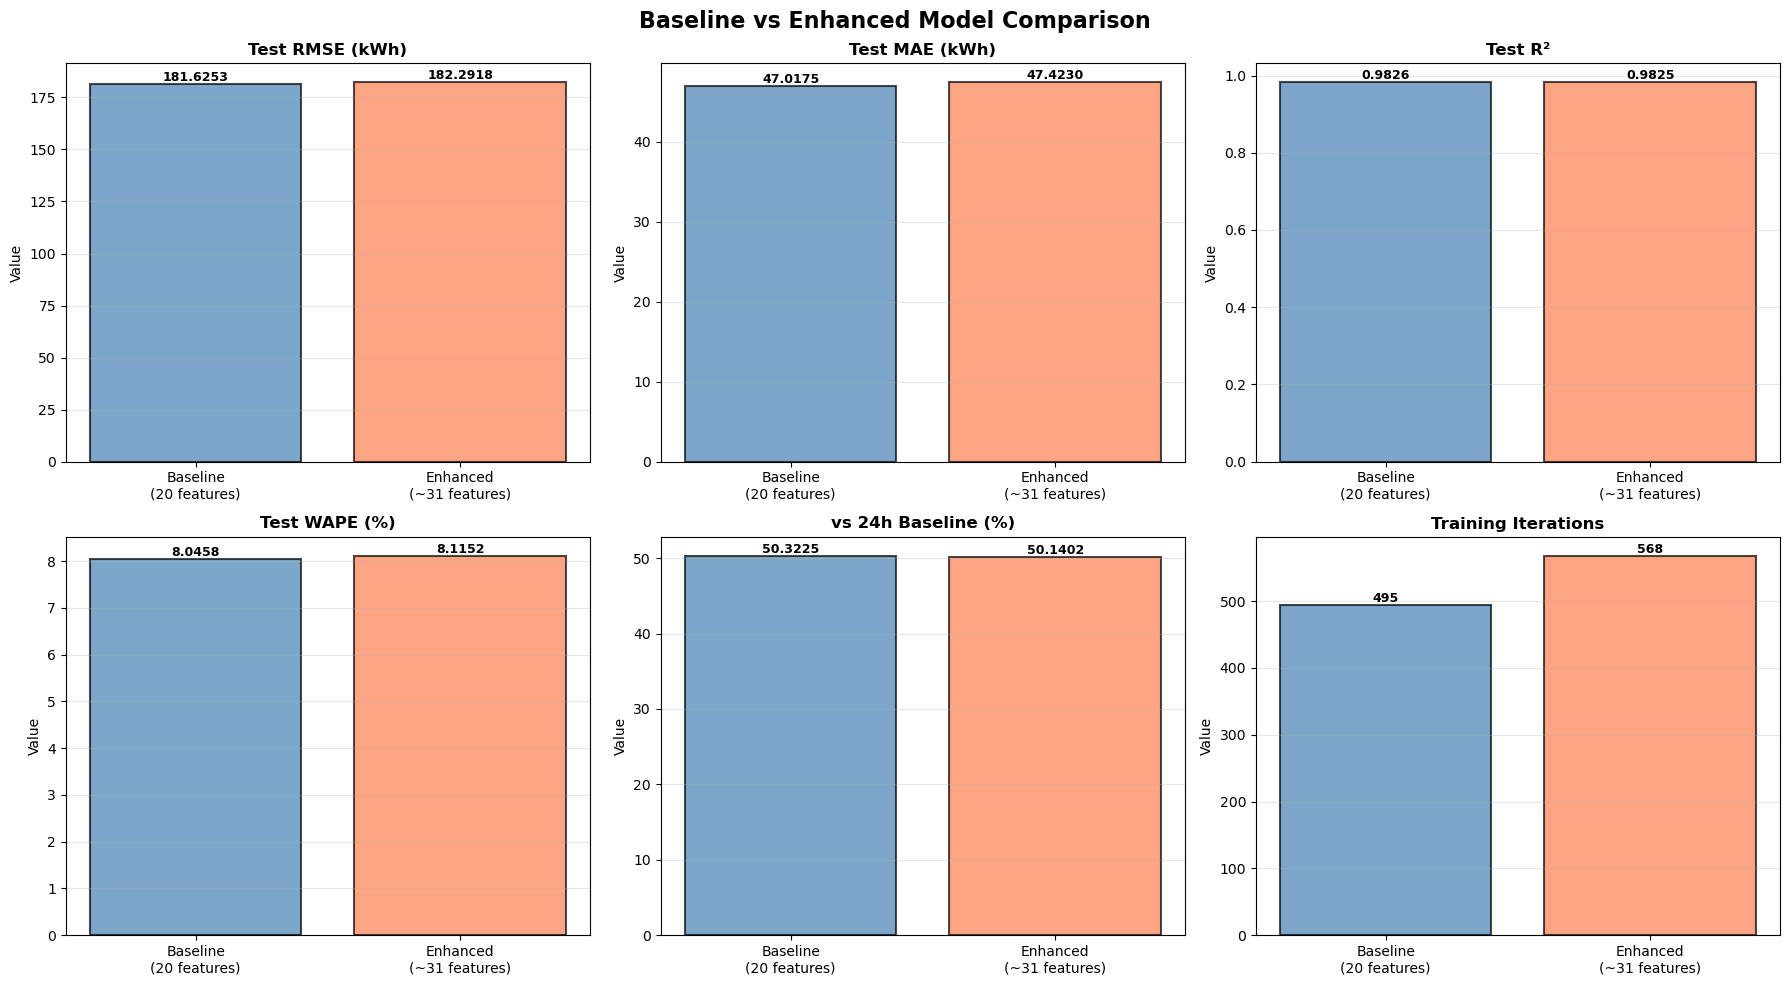

In [4]:
# Visualization: Model Comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = [
    ('test_rmse', 'Test RMSE (kWh)', 'lower'),
    ('test_mae', 'Test MAE (kWh)', 'lower'),
    ('test_r2', 'Test R²', 'higher'),
    ('test_wape', 'Test WAPE (%)', 'lower'),
    ('improvement_vs_24h', 'vs 24h Baseline (%)', 'higher'),
    ('best_iteration', 'Training Iterations', 'lower')
]

for idx, (metric, title, better) in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    values = [model1[metric], model2[metric]]
    
    # Color based on improvement
    if better == 'lower':
        colors = ['steelblue' if v == min(values) else 'coral' for v in values]
    else:
        colors = ['steelblue' if v == max(values) else 'coral' for v in values]
    
    bars = ax.bar(['Baseline\n(20 features)', 'Enhanced\n(~31 features)'], values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('Value', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (bar, v) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{v:.4f}' if isinstance(v, float) else str(v),
                ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.suptitle('Baseline vs Enhanced Model Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/model_comparison.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: ../reports/model_comparison.png")
plt.show()

## Summary & Recommendations

In [ ]:
print("\n" + "="*100)
print("FINAL SUMMARY & RECOMMENDATIONS")
print("="*100)

print("\n1️⃣ BASELINE VS ENHANCED MODEL:")
if test_rmse_diff < 0:
    print(f"   ✅ Enhanced model is BETTER by {abs(test_rmse_pct):.2f}%")
    print(f"   → Recommendation: KEEP enhanced model with {model2['num_features']} features")
else:
    print(f"   ❌ Baseline model is BETTER by {abs(test_rmse_pct):.2f}%")
    print(f"   → Recommendation: REVERT to baseline model with {model1['num_features']} features")

print(f"\n2️⃣ OVERFITTING ASSESSMENT:")
if model2_overfit <= 1.10:
    print(f"   ✅ Good generalization (Test/Train ratio: {model2_overfit:.4f})")
elif model2_overfit <= 1.15:
    print(f"   ⚠️ Slight overfitting (Test/Train ratio: {model2_overfit:.4f})")
    print(f"   → Consider: Increase regularization (lambda_l1, lambda_l2)")
    print(f"   → Consider: Reduce max_depth or num_leaves")
else:
    print(f"   ❌ Significant overfitting (Test/Train ratio: {model2_overfit:.4f})")
    print(f"   → Urgently increase regularization")
    print(f"   → Consider removing less important features")

print(f"\n3️⃣ ACTIONABLE RECOMMENDATIONS:")

# Recommendation based on overfitting
if model2_overfit > 1.10:
    print(f"\n   🔧 TO REDUCE OVERFITTING:")
    print(f"      • Increase lambda_l1 from 0.1 to 0.3")
    print(f"      • Increase lambda_l2 from 0.1 to 0.3")
    print(f"      • Reduce max_depth from 10 to 8")
    print(f"      • Reduce num_leaves from 64 to 48")
    print(f"      • Increase min_data_in_leaf from 20 to 50")

print(f"\n   📊 NEXT STEPS:")
print(f"      1. Review model comparison visualization: ../reports/model_comparison.png")
print(f"      2. Run rolling window backtesting in new_lgbm_model.ipynb for seasonal validation")
print(f"      3. Check comprehensive analysis in: ../reports/comprehensive_analysis_*.png")
print(f"      4. If overfitting detected, adjust hyperparameters and retrain")

print("\n" + "="*100)
print("✅ MODEL COMPARISON COMPLETE")
print("="*100)


FINAL SUMMARY & RECOMMENDATIONS

1️⃣ BASELINE VS ENHANCED MODEL:
   ❌ Baseline model is BETTER by 0.37%
   → Recommendation: REVERT to baseline model with 20 features

2️⃣ OVERFITTING ASSESSMENT:
   ✅ Good generalization (Test/Train ratio: 1.0868)

3️⃣ SEASONAL STABILITY:
   RMSE variability across months: ± 8.74 kWh
   RMSE range: 28.59 kWh (Apr - Jun)
   ✅ Consistent performance across seasons

4️⃣ ACTIONABLE RECOMMENDATIONS:

   📊 NEXT STEPS:
      1. Review rolling window results in: ../reports/rolling_window_backtest.csv
      2. Check seasonal plots in: ../reports/rolling_window_seasonal_analysis.png
      3. If needed, re-run with adjusted hyperparameters
      4. Compare with baseline in: ../reports/model_comparison.png

✅ ANALYSIS COMPLETE
